# Intro

Let's do experiment on 3 different optimizers:

* SGD
* SGD with mini-batch
* SGD with momentum

Experiment will include 2 easily differentiable classes with 1 outlier. We aim to see how 3 different optimizers will behave with this single outlier.

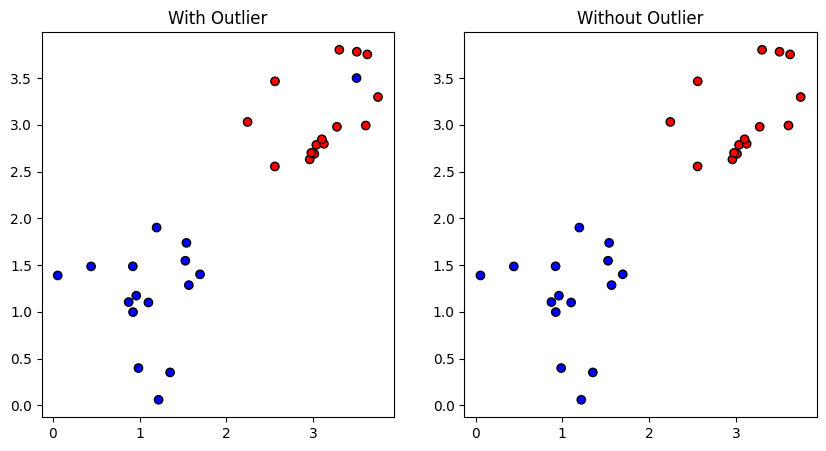

In [186]:
# @title
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nna
from sklearn.model_selection import train_test_split
import copy

n_per_clust = 15
blur = .5

A = [1,1]
B = [3,3]

a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]

# Outlier
outlier = np.array([[3.5],[3.5]])
outlier_label = [0]

# Without Outlier
labels_not = np.hstack((
    np.zeros(n_per_clust),
    np.ones(n_per_clust)
))
data_not = np.hstack((
    a, b
)).T

# With Outlier
labels_ot = np.hstack((
    np.zeros(n_per_clust),
    np.ones(n_per_clust),
    outlier_label
))
data_ot = np.hstack((
    a, b, outlier
)).T

# Data
labels_ot = torch.tensor(labels_ot, dtype = torch.long)
data_ot = torch.tensor(data_ot, dtype = torch.float)
labels_not = torch.tensor(labels_not, dtype = torch.long)
data_not = torch.tensor(data_not, dtype = torch.float)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10,5))
# with outlier
ax[0].scatter(data_ot[:,0], data_ot[:,1], c=labels_ot, cmap='bwr', edgecolor='k')
ax[0].set_title('With Outlier')
# without outlier
ax[1].scatter(data_not[:,0], data_not[:,1], c=labels_not, cmap='bwr', edgecolor='k')
ax[1].set_title('Without Outlier')
plt.show()

In [177]:
# @title
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

def ModelTrain(name_optim, OptimCls, optim_kwargs, epochs, batch_size=None):
    loss_fn = nn.CrossEntropyLoss()

    # base model
    model_base = nn.Linear(2,2)

    # copies for both experiments
    model_not = copy.deepcopy(model_base)
    model_ot = copy.deepcopy(model_base)

    opt_not = OptimCls(model_not.parameters(), **optim_kwargs)
    opt_ot = OptimCls(model_ot.parameters(), **optim_kwargs)

    # history
    losses_not, accs_not = [], []
    losses_ot, accs_ot = [], []

    # --- training with outlier ---
    for epoch in range(epochs):
        if batch_size is None:  # full batch
            y_hat = model_ot(data_ot)
            loss = loss_fn(y_hat, labels_ot)
            opt_ot.zero_grad()
            loss.backward()
            opt_ot.step()
            losses_ot.append(loss.item())
            acc = 100 * torch.mean((torch.argmax(y_hat, axis=1) == labels_ot).float())
            accs_ot.append(acc.item())
        else:  # mini-batch
            idx = torch.randperm(len(data_ot))
            for i in range(0, len(data_ot), batch_size):
                batch_idx = idx[i:i+batch_size]
                xb, yb = data_ot[batch_idx], labels_ot[batch_idx]
                y_hat = model_ot(xb)
                loss = loss_fn(y_hat, yb)
                opt_ot.zero_grad()
                loss.backward()
                opt_ot.step()
            # record after one epoch
            with torch.no_grad():
                y_hat = model_ot(data_ot)
                losses_ot.append(loss_fn(y_hat, labels_ot).item())
                acc = 100 * torch.mean((torch.argmax(y_hat, axis=1) == labels_ot).float())
                accs_ot.append(acc.item())

    # --- training without outlier ---
    for epoch in range(epochs):
        if batch_size is None:  # full batch
            y_hat = model_not(data_not)
            loss = loss_fn(y_hat, labels_not)
            opt_not.zero_grad()
            loss.backward()
            opt_not.step()
            losses_not.append(loss.item())
            acc = 100 * torch.mean((torch.argmax(y_hat, axis=1) == labels_not).float())
            accs_not.append(acc.item())
        else:  # mini-batch
            idx = torch.randperm(len(data_not))
            for i in range(0, len(data_not), batch_size):
                batch_idx = idx[i:i+batch_size]
                xb, yb = data_not[batch_idx], labels_not[batch_idx]
                y_hat = model_not(xb)
                loss = loss_fn(y_hat, yb)
                opt_not.zero_grad()
                loss.backward()
                opt_not.step()
            # record after one epoch
            with torch.no_grad():
                y_hat = model_not(data_not)
                losses_not.append(loss_fn(y_hat, labels_not).item())
                acc = 100 * torch.mean((torch.argmax(y_hat, axis=1) == labels_not).float())
                accs_not.append(acc.item())

    # decision boundary helper
    def plot_boundary(m, X, y, title, ax):
        W = m.weight.detach().numpy()
        b = m.bias.detach().numpy()
        w = W[1] - W[0]
        b = b[1] - b[0]
        xx = np.linspace(0,5,100)
        yy = -(w[0]*xx + b)/w[1]
        ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')
        ax.plot(xx, yy, 'k--')
        ax.set_title(title)

    # plots
    fig, ax = plt.subplots(2,2, figsize=(10,8))
    fig.suptitle(name_optim, fontsize=16, fontweight="bold")

    plot_boundary(model_not, data_not, labels_not, "Boundary (no outlier)", ax[0][0])
    plot_boundary(model_ot, data_ot, labels_ot, "Boundary (with outlier)", ax[0][1])

    ax[1][0].plot(losses_not, label="no outlier")
    ax[1][0].plot(losses_ot, label="with outlier")
    ax[1][0].set_title("Loss")
    ax[1][0].legend()

    ax[1][1].plot(accs_not, label="no outlier")
    ax[1][1].plot(accs_ot, label="with outlier")
    ax[1][1].set_title("Accuracy (%)")
    ax[1][1].legend()

    ymin, ymax = data_ot[:,1].min().item(), data_ot[:,1].max().item()

    for i in range(2):
        ax[0][i].set_ylim(ymin, ymax)

    plt.tight_layout()
    plt.show()

    # return (losses_not, losses_ot), (accs_not, accs_ot)


Stochastic gradient descent

$$ w \leftarrow w - \eta d L $$

* Change the weights after each sample. This is great when all samples are really similar to each other.

* But SGD learning is very sensitive, and can lead to volatile changes based on non-representative samples

SGD on mini-batches

$$ w \leftarrow w - \eta d J$$

* Mini-batch SGD: Change the weights after N samples. Average losses across N samples.

* Sometimes more robust than SGD, except when samples are similar to each other

SGD with momentum


$$ v_t = (1-\beta) v_t + \beta v_{t-1} $$
$$ \beta \in [0,1] $$
$$ w \leftarrow w - \eta v $$

Interpretation: Update current weights according to a weighted average of current and previous costs.

Typical values of $\beta$ are .9 to .99

* Smoothing via weighted averaging

* Each data point is a weighted combination of itself and the previous data point




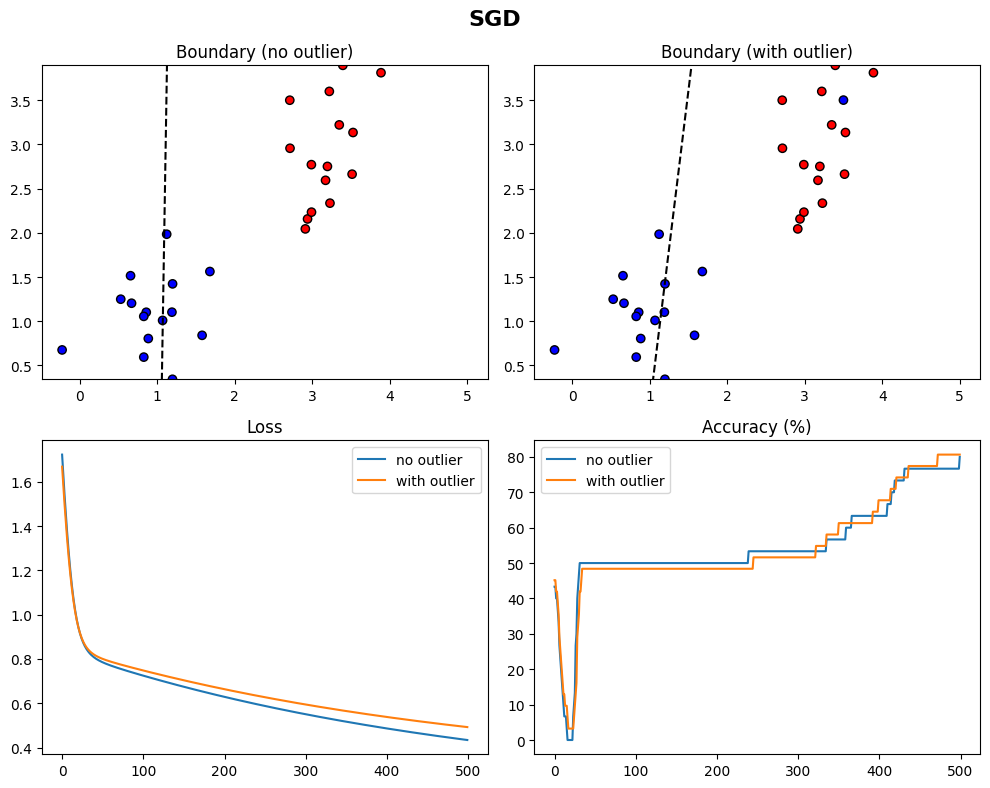

In [182]:
# @title
ModelTrain("SGD", optim.SGD, {"lr":1e-2}, epochs=500)

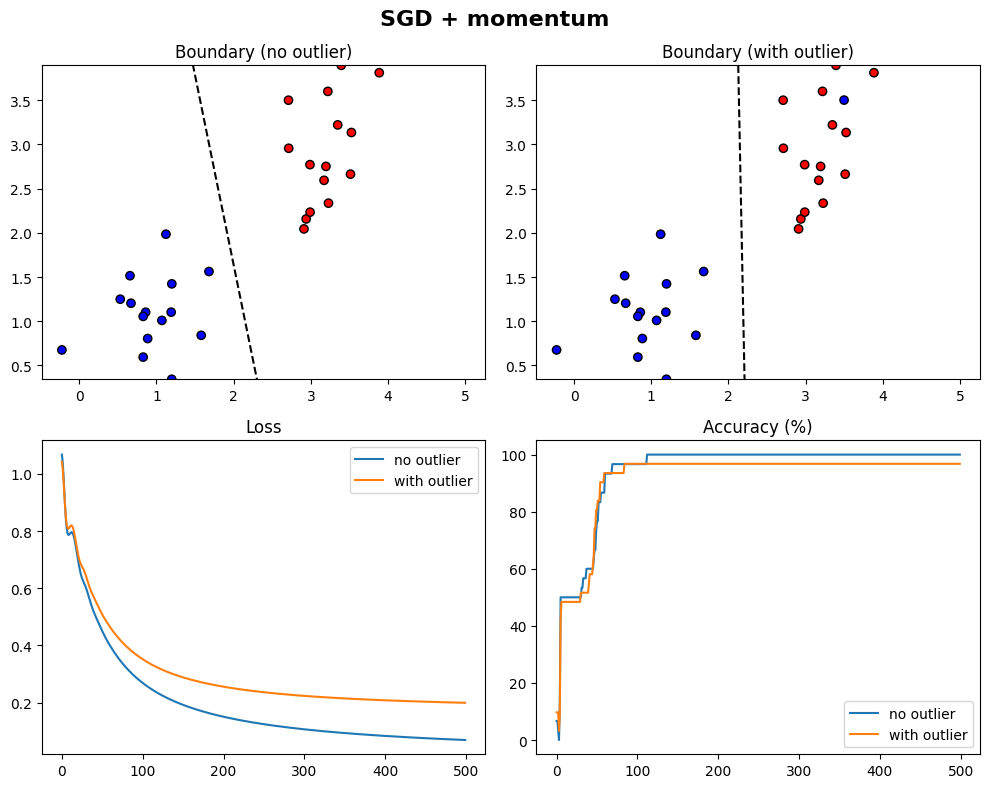

In [183]:
# @title
ModelTrain("SGD + momentum", optim.SGD, {"lr":1e-2, "momentum":0.9}, epochs=500)

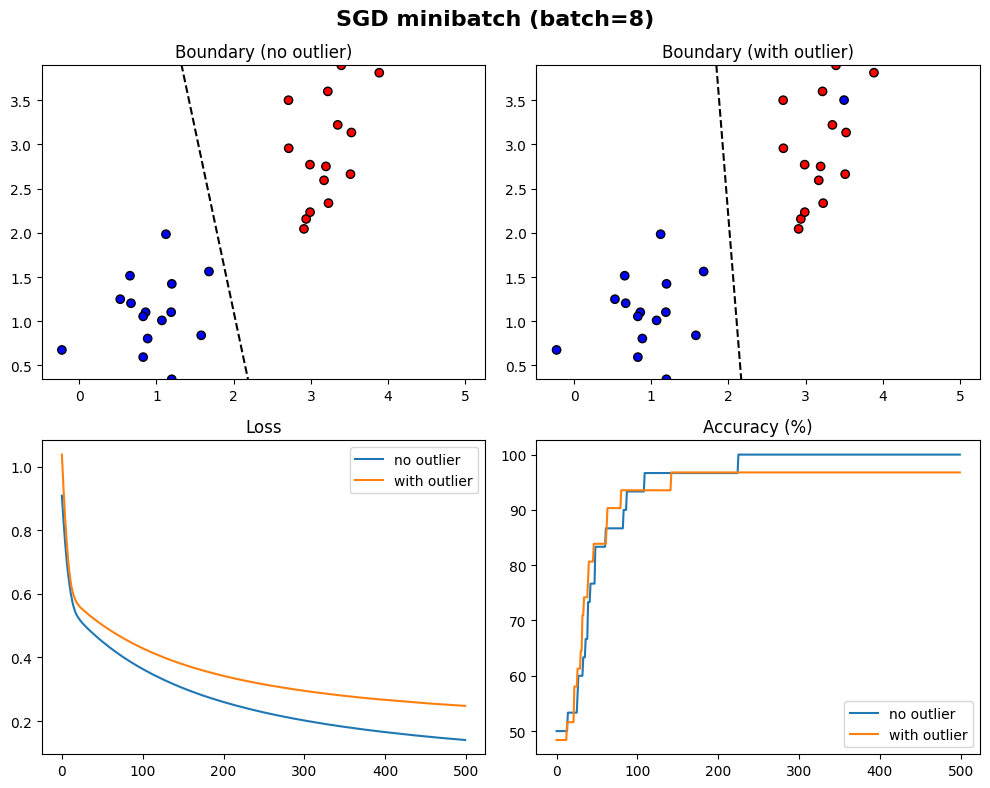

In [184]:
# @title
ModelTrain("SGD minibatch (batch=8)", optim.SGD, {"lr":1e-2}, epochs=500, batch_size=8)

We can see that SGD with momentum outperforms both vanilla SGD and SGD with mini-batches. The addition of momentum accelerates training by smoothing the gradient updates, which allows the loss function to converge within roughly 500 epochs, as shown in our experiment.

Surprisingly, the presence of an outlier introduced a larger gap between the loss curves (with outlier vs. without outlier) in the cases of SGD with momentum and SGD with mini-batches. In contrast, although classic SGD performed worse overall, it actually handled the outlier more robustly: the difference between training with and without the outlier was smaller compared to the other two methods.

This outcome makes sense: momentum and mini-batch SGD speed up convergence, but their faster and more aggressive updates make them more sensitive to outliers. Vanilla SGD, while slower and less efficient in general, applies smaller, more conservative updates, which in this case made it less affected by the single outlier.

# SGD With Momentum on Qwarks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-2923486342.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## Data

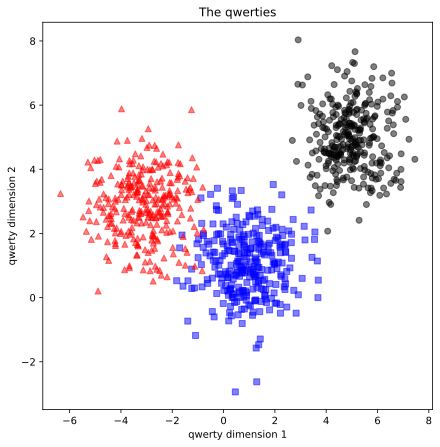

In [41]:
n_per_clust = 300
blur = 1

A = [1,1]
B = [5,5]
C = [-3,3]

a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust)*blur]
b = [B[0] + np.random.randn(n_per_clust)* blur, B[1] + np.random.randn(n_per_clust)*blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust)*blur]

labels_np = np.hstack((
    np.zeros(n_per_clust),
    np.ones(n_per_clust),
    1 + np.ones(n_per_clust)
))

data_np = np.hstack((
    a,b,c
)).T

data = torch.tensor(data_np, dtype = torch.float)
labels = torch.tensor(labels_np, dtype = torch.long)

fig = plt.figure(figsize = (7,7))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs', alpha =.5)
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko', alpha =.5)
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0], 1], 'r^', alpha =.5)
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## Train Test Split

In [42]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

## Model

In [45]:
def createQwertyNet(momentum):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(2, 8)

      self.fc1 = nn.Linear(8,8)

      self.output = nn.Linear(8,3)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      return self.output(x)

  net = qwertyNet()

  loss_fn = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum = momentum)

  return net, loss_fn, optimizer

createQwertyNet(momentum = .5)

(qwertyNet(
   (input): Linear(in_features=2, out_features=8, bias=True)
   (fc1): Linear(in_features=8, out_features=8, bias=True)
   (output): Linear(in_features=8, out_features=3, bias=True)
 ),
 CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0.5
     nesterov: False
     weight_decay: 0
 ))

## Training

In [58]:
def ModelTrain(epochs, momentum):

  net, loss_fn, optimizer = createQwertyNet(momentum)

  losses = torch.zeros(epochs)
  train_acc = []
  test_acc = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc.append(np.mean(batch_acc))

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc.append(
        100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    )
  # end epochs

  return train_acc, test_acc, losses, net

In [73]:
train_acc, test_acc, losses, net = ModelTrain(epochs = 10, momentum = 0.5)

## Experiment

In [65]:
momenta = [0,.5,.9,.95,.999]
epochs = 3
results = np.zeros((epochs, len(momenta), 3))

for idx, mom in enumerate(momenta):
  train_acc, test_acc, losses, net = ModelTrain(epochs = epochs, momentum = mom)
  results[:, idx, 0] = losses
  results[:, idx, 1] = train_acc
  results[:, idx, 2] = test_acc

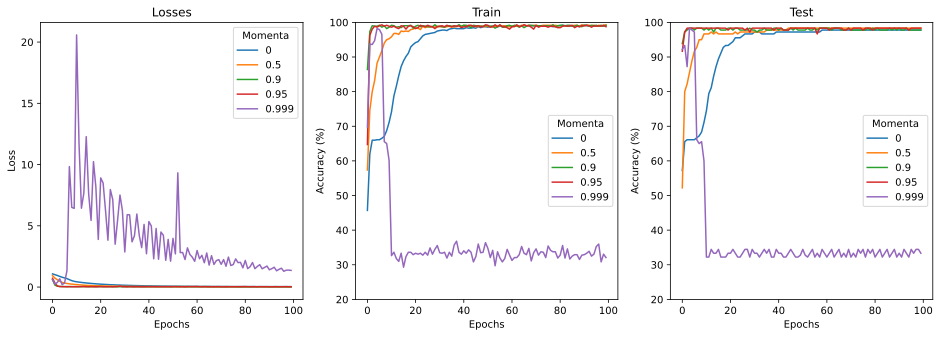

In [63]:
fig, ax = plt.subplots(1,3,figsize = (12,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  ax[i].legend(momenta, title = 'Momenta')
  ax[i].set_xlabel('Epochs')
  if i == 0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')
plt.show()